# mlr3:pipelines

`mlr3pipelines`是一种数据流编程套件，完整的机器学习工作流可被称为`Graph/Pipelines`，包含数据预处理、建模、多个模型比较等，不同的模型需要不同的数据预处理方法，另外还有集成学习、各种非线性模型等，这些都可以通过`mlr3pipelines`解决。

数据预处理的`R`包有很多，比如`caret`、`recipes`等，`mlr3pipelines`创造性的使用了图流的方式。

<image src="images/pipelines.webp">

## pipeops
进行数据预处理的各种方法在`mlr3pipelines`中被称为`pipeops`，目前基本涵盖常见的数据预处理方法，比如独热编码、稀疏矩阵、缺失值处理、降维、数据标准化、因子分组等等。

可以用来连接预处理和模型，或者构建复杂的统计建模步骤，例如多种不同的预处理连接多种不同的模型等

查看所有的pipeops

In [23]:
library(mlr3pipelines)
as.data.table(mlr_pipeops) # 目前共有64种


key,label,packages,tags,feature_types,input.num,output.num,input.type.train,input.type.predict,output.type.train,output.type.predict
<chr>,<chr>,<list>,<list>,<list>,<int>,<int>,<list>,<list>,<list>,<list>
boxcox,Box-Cox Transformation of Numeric Features,"mlr3pipelines, bestNormalize",data transform,"numeric, integer",1,1,Task,Task,Task,Task
branch,Path Branching,mlr3pipelines,meta,NA,1,NA,*,*,*,*
chunk,Chunk Input into Multiple Outputs,mlr3pipelines,meta,NA,1,NA,Task,Task,Task,Task
classbalancing,Class Balancing,mlr3pipelines,"imbalanced data, data transform","logical , integer , numeric , character, factor , ordered , POSIXct",1,1,TaskClassif,TaskClassif,TaskClassif,TaskClassif
classifavg,Majority Vote Prediction,"mlr3pipelines, stats",ensemble,NA,NA,1,NULL,PredictionClassif,NULL,PredictionClassif
classweights,Class Weights for Sample Weighting,mlr3pipelines,"imbalanced data, data transform","logical , integer , numeric , character, factor , ordered , POSIXct",1,1,TaskClassif,TaskClassif,TaskClassif,TaskClassif
colapply,Apply a Function to each Column of a Task,mlr3pipelines,data transform,"logical , integer , numeric , character, factor , ordered , POSIXct",1,1,Task,Task,Task,Task
collapsefactors,Collapse Factors,mlr3pipelines,data transform,"factor , ordered",1,1,Task,Task,Task,Task
colroles,Change Column Roles of a Task,mlr3pipelines,data transform,"logical , integer , numeric , character, factor , ordered , POSIXct",1,1,Task,Task,Task,Task


看到有很多数据预处理方法了，但其实常用的也就10来种左右。

创建预处理步骤可通过以下方法：

In [2]:
pca <- mlr_pipeops$get("pca")

# 或者用简便写法
pca <- po("pca")


非常重要的一点是，不仅能创建预处理步骤，也可以用这种方法选择算法，选择特征选择方法等：

In [24]:
# 选择学习器/算法
library(mlr3)
learner <- po("learner", lrn("classif.rpart"))

# 选择特征选择的方法并设置参数
filter <- po("filter",
    filter = mlr3filters::flt("variance"),
    filter.frac = 0.5
)


## mlr3pipelines中的管道符: %>>%

这是mlr3团队发明的专用管道符，可用于连接不同的预处理步骤、预处理和模型等操作：

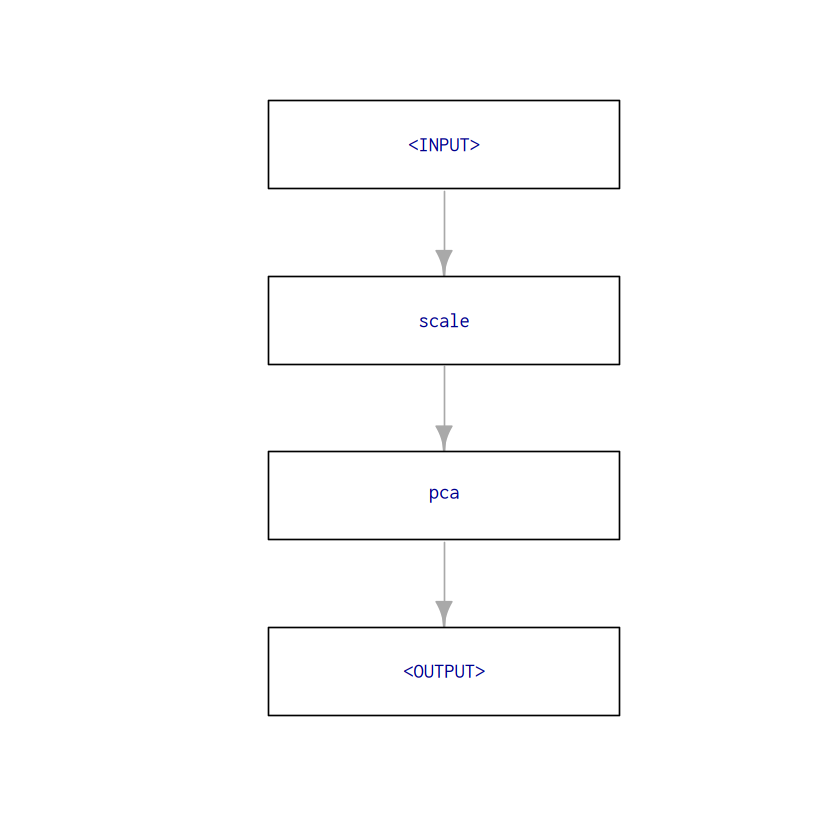

In [4]:
gr <- po("scale") %>>% po("pca")
gr$plot(html = F)


很多强大的操作都是基于此管道符运行的。

## 建立模型
一个简单的例子，先预处理数据，再训练

In [5]:
# 连接预处理和模型，有点类似tidymodels的workflow
mutate <- po("mutate")
filter <- po("filter",
    filter = mlr3filters::flt("variance"),
    param_vals = list(filter.frac = 0.5)
)

graph <- mutate %>>%
    filter %>>%
    po("learner", learner = lrn("classif.rpart"))


现在这个graph就变成了一个含有预处理步骤的学习器（learner），可以像前面介绍的那样直接用于训练、预测：

In [6]:
task <- tsk("iris")
graph$train(task)


$classif.rpart.output
NULL

预测

In [7]:
graph$predict(task)


$classif.rpart.output
<PredictionClassif> for 150 observations:
    row_ids     truth  response
          1    setosa    setosa
          2    setosa    setosa
          3    setosa    setosa
---                            
        148 virginica virginica
        149 virginica virginica
        150 virginica virginica


除此之外，还可以把graph变成一个`GraphLearner`对象，用于`resample`和`benchmark`等

In [8]:
glrn <- as_learner(graph) # 变成graphlearner

cv3 <- rsmp("cv", folds = 5)
resample(task, glrn, cv3)


INFO  [21:48:18.320] [mlr3] Applying learner 'mutate.variance.classif.rpart' on task 'iris' (iter 1/5)
INFO  [21:48:18.405] [mlr3] Applying learner 'mutate.variance.classif.rpart' on task 'iris' (iter 2/5)
INFO  [21:48:18.467] [mlr3] Applying learner 'mutate.variance.classif.rpart' on task 'iris' (iter 3/5)
INFO  [21:48:18.528] [mlr3] Applying learner 'mutate.variance.classif.rpart' on task 'iris' (iter 4/5)
INFO  [21:48:18.587] [mlr3] Applying learner 'mutate.variance.classif.rpart' on task 'iris' (iter 5/5)


<ResampleResult> with 5 resampling iterations
 task_id                    learner_id resampling_id iteration warnings errors
    iris mutate.variance.classif.rpart            cv         1        0      0
    iris mutate.variance.classif.rpart            cv         2        0      0
    iris mutate.variance.classif.rpart            cv         3        0      0
    iris mutate.variance.classif.rpart            cv         4        0      0
    iris mutate.variance.classif.rpart            cv         5        0      0

在很多数据预处理步骤中也是有参数需要调整的，mlr3pipelines不仅可以用于调整算法的超参数，还可以调整预处理中的参数。

In [25]:
library(paradox)

ps <- ps(
  classif.rpart.cp = p_dbl(0, 0.05), # 算法中的参数
  variance.filter.frac = p_dbl(0.25, 1) # 特征选择方法中的参数
)


In [26]:
library(mlr3tuning)

instance <- TuningInstanceBatchSingleCrit$new(
    task = task,
    learner = glrn,
    resampling = rsmp("holdout", ratio = 0.7),
    measure = msr("classif.acc"),
    search_space = ps,
    terminator = trm("evals", n_evals = 20)
)


In [11]:
tuner <- tnr("random_search")

lgr::get_logger("mlr3")$set_threshold("warn")
lgr::get_logger("bbotk")$set_threshold("warn")


In [12]:
tuner$optimize(instance)


classif.rpart.cp,variance.filter.frac,learner_param_vals,x_domain,classif.acc
<dbl>,<dbl>,<list>,<list>,<dbl>
0.02393091,0.4039542,"0.00000000, 0.40395421, 1.00000000, 0.00000000, 0.02393091","0.02393091, 0.40395421",0.9555556


In [13]:
instance$result_y


classif.acc 
  0.9555556

In [14]:
instance$result_learner_param_vals


$mutate.mutation
list()

$mutate.delete_originals
[1] FALSE

$variance.filter.frac
[1] 0.4039542

$variance.na.rm
[1] TRUE

$classif.rpart.xval
[1] 0

$classif.rpart.cp
[1] 0.02393091

可以看到结果直接给出了算法的超参数和特征选择中的参数。

## 非线性graph
- Branching: 一个点通往多个分支，例如在比较多个特征选择方法时很有用。只有一条路会被执行。
- Copying: 一个点通往多个分支，所有的分支都会被执行，但是只能1次执行1个分支，并行计算目前还不支持。
- Stacking: 单个图被彼此堆叠，一个图的输出是另一个图的输入。


### branching & copying
使用`PipeOpBranch`和`PipeOpUnbranch`实现分支操作，分支操作的概念如下图所示：

<image src="images/branching & copying.webp">



下面一个例子演示了分支操作，分支之后一定要解除分支：

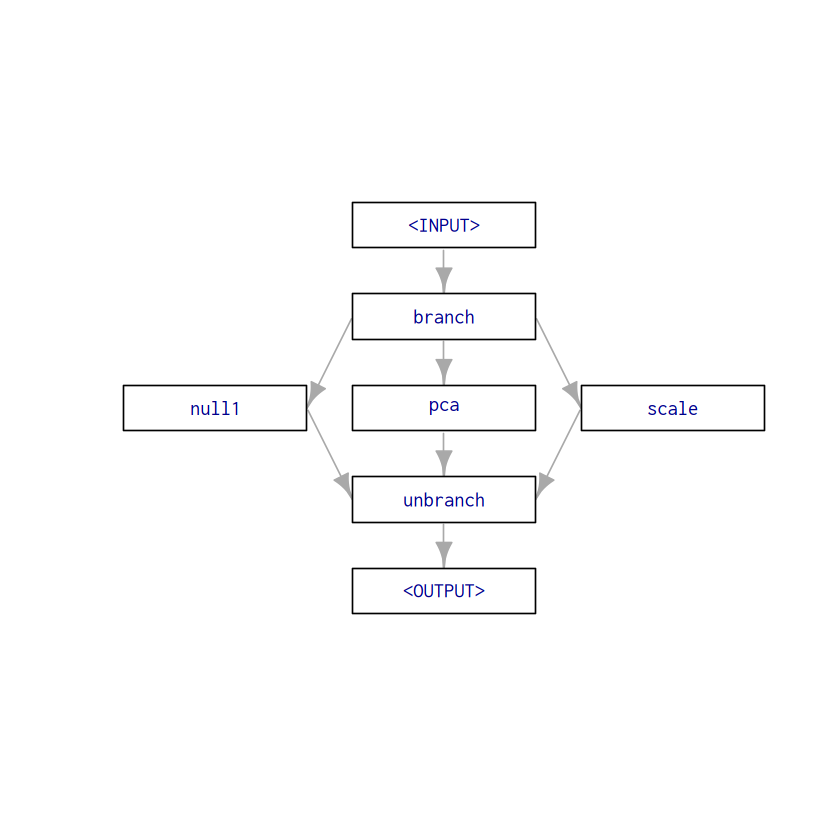

In [15]:
graph <- po("branch", c("nop", "pca", "scale")) %>>% # 开始分支
    gunion(list(
        po("nop", id = "null1"), # 分支1，并且取了个名字null1
        po("pca"), # 分支2
        po("scale") # 分支3
    )) %>>%
    po("unbranch", c("nop", "pca", "scale")) # 结束分支

graph$plot(html = F)


### bagging
属于集成学习的一种，概念不做介绍，感兴趣的可自行学习，其概念可查看下图：

<image src="images/bagging.webp">

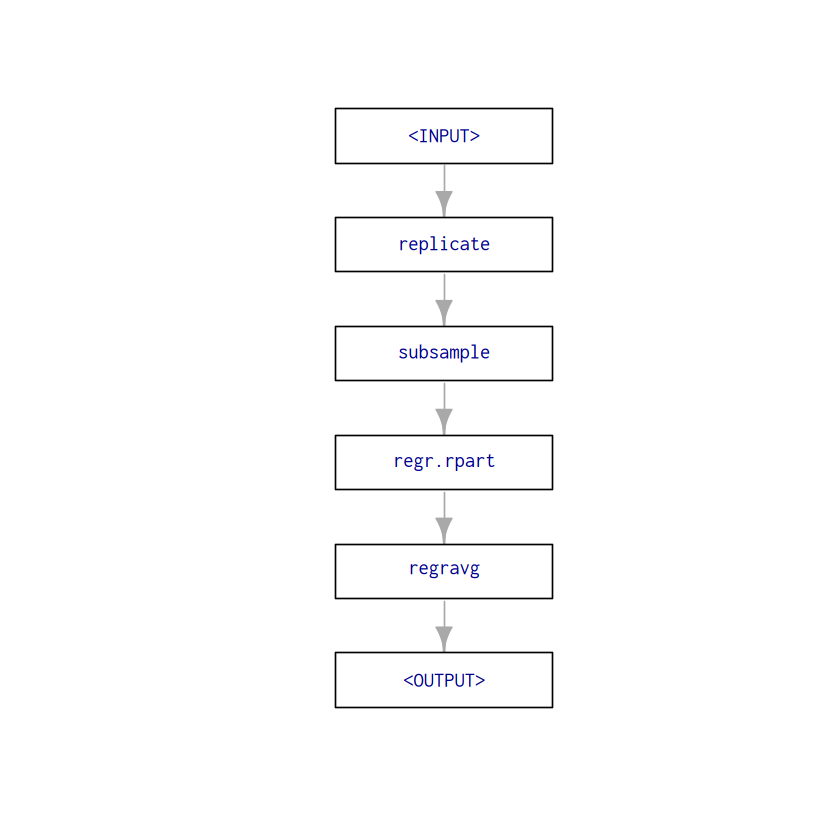

In [19]:
gr <- ppl("bagging",
  graph = po(lrn("regr.rpart")),
  averager = po("regravg", collect_multiplicity = TRUE)
)

gr$plot(html = FALSE)


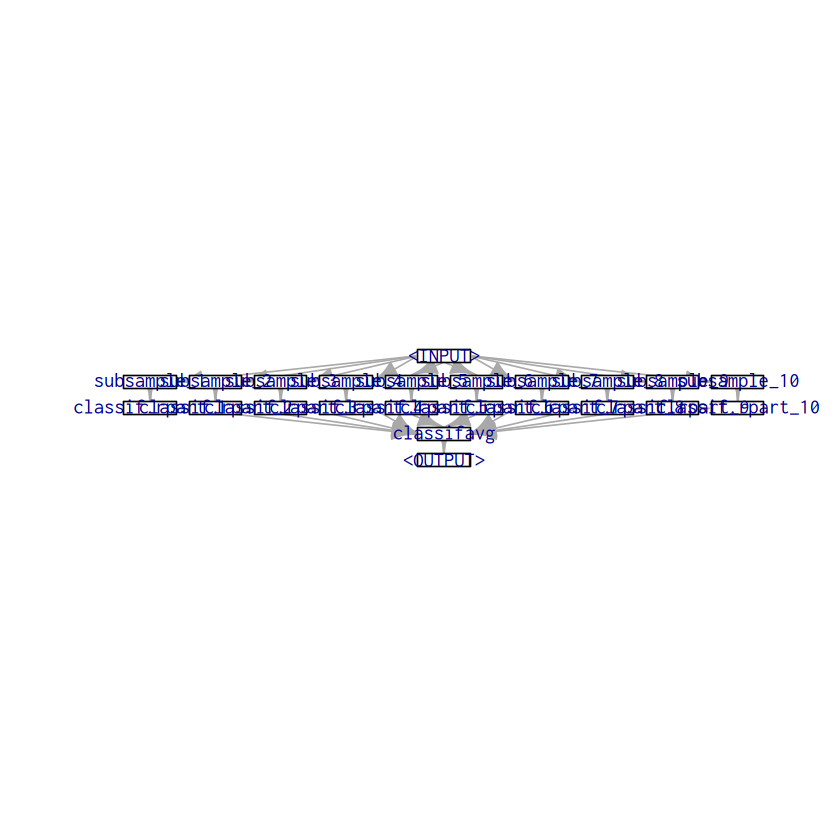

In [20]:
single_pred <- po("subsample", frac = 0.7) %>>%
  po("learner", lrn("classif.rpart")) # 建立一个模型

pred_set <- ppl("greplicate", single_pred, 10L) # 复制10次

bagging <- pred_set %>>%
  po("classifavg", innum = 10)

bagging$plot(html = FALSE)


把上面的对象变成一个`GraphLearner`，然后就可以进行训练和预测了：



In [21]:
task <- tsk("iris")
split <- partition(task, ratio = 0.7, stratify = T)


baglrn <- as_learner(bagging)
baglrn$train(task, row_ids = split$train)
baglrn$predict(task, row_ids = split$test)


<PredictionClassif> for 45 observations:
    row_ids     truth  response prob.setosa prob.versicolor prob.virginica
          3    setosa    setosa           1             0.0            0.0
          4    setosa    setosa           1             0.0            0.0
         11    setosa    setosa           1             0.0            0.0
---                                                                       
        141 virginica virginica           0             0.0            1.0
        147 virginica virginica           0             0.1            0.9
        149 virginica virginica           0             0.0            1.0

## stacking
另一种提高模型性能的方法，概念可看下图：

<image src = "images/stacking.webp">

这里为了防止过拟合，使用PipeOpLearnerCV预测袋外数据，它可以在数据内部自动执行嵌套重抽样。

首先创建level 0学习器，然后复制一份，并取一个名字：

In [28]:
lrn <- lrn("classif.rpart")
lrn_0 <- po("learner_cv", lrn$clone())
lrn_0$id <- "rpart_cv"


然后联合使用`gunion`和`PipeOpNOP`，把没动过的task传到下一个level，这样经过决策树的task和没处理过的task就能一起传到下一个level了。

In [29]:
level_0 <- gunion(list(lrn_0, po("nop")))


把上面传下来的东西联合到一起：

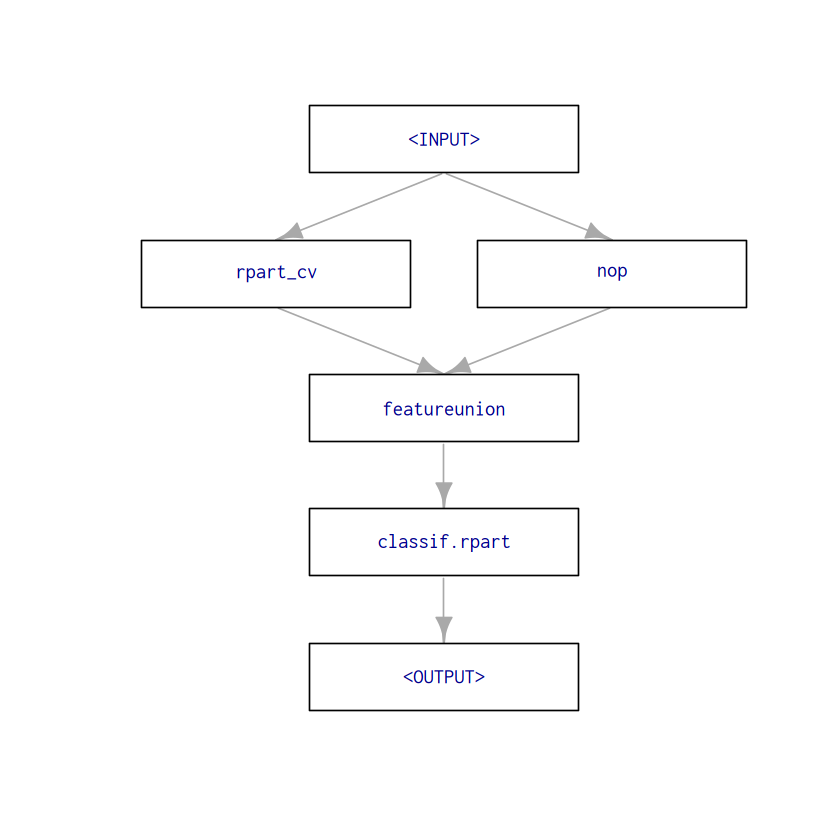

In [30]:
combined <- level_0 %>>% po("featureunion", 2)
stack <- combined %>>% po("learner", lrn$clone())
stack$plot(html = FALSE)


然后就可以进行训练、预测了：

In [31]:
stacklrn <- as_learner(stack)
stacklrn$train(task, split$train)
stacklrn$predict(task, split$test)


<PredictionClassif> for 45 observations:
    row_ids     truth  response
          3    setosa    setosa
          4    setosa    setosa
         11    setosa    setosa
---                            
        141 virginica virginica
        147 virginica virginica
        149 virginica virginica

## 一个超级复杂的例子
这个例子有多个不同的预处理步骤，使用多个不同的算法。



Warning message:
“Package 'glmnet' required but not installed for Learner 'classif.glmnet'”


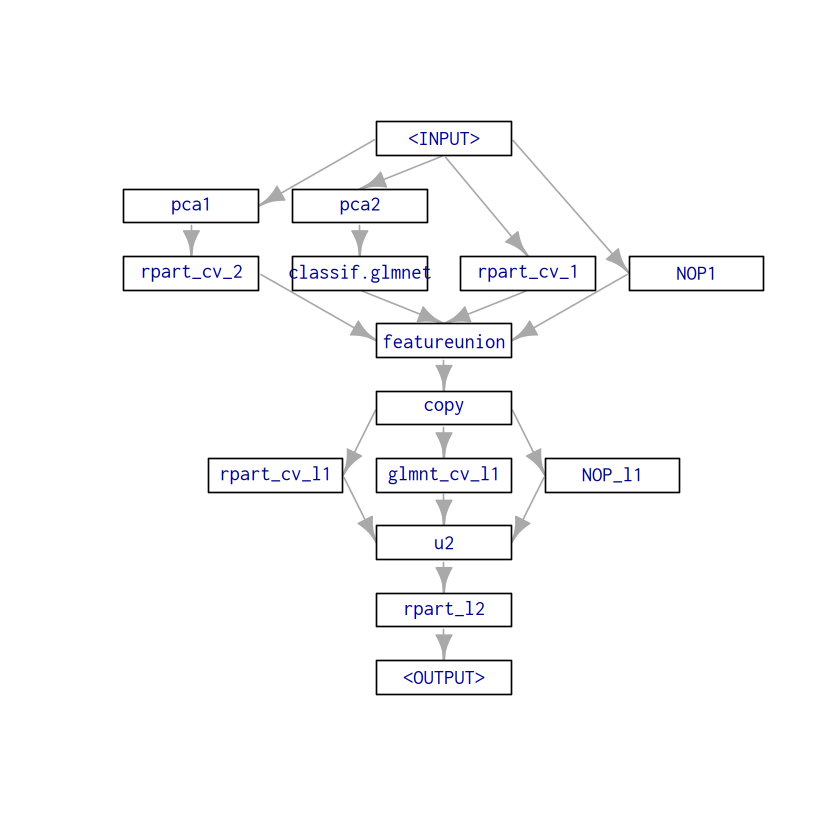

In [32]:
library("magrittr")
library("mlr3learners")

rprt <- lrn("classif.rpart", predict_type = "prob")
glmn <- lrn("classif.glmnet", predict_type = "prob")

# 创建学习器
lrn_0 <- po("learner_cv", rprt, id = "rpart_cv_1")
lrn_0$param_set$values$maxdepth <- 5L
lrn_1 <- po("pca", id = "pca1") %>>% po("learner_cv", rprt, id = "rpart_cv_2")
lrn_1$param_set$values$rpart_cv_2.maxdepth <- 1L
lrn_2 <- po("pca", id = "pca2") %>>% po("learner_cv", glmn)

# 第0层
level_0 <- gunion(list(lrn_0, lrn_1, lrn_2, po("nop", id = "NOP1")))

# 第1层
level_1 <- level_0 %>>%
    po("featureunion", 4) %>>%
    po("copy", 3) %>>%
    gunion(list(
        po("learner_cv", rprt, id = "rpart_cv_l1"),
        po("learner_cv", glmn, id = "glmnt_cv_l1"),
        po("nop", id = "NOP_l1")
    ))

# 第2层
level_2 <- level_1 %>>%
    po("featureunion", 3, id = "u2") %>>%
    po("learner", rprt, id = "rpart_l2")


level_2$plot(html = FALSE)


下面就可以进行训练、预测：

In [35]:
task <- tsk("iris")
lrn <- as_learner(level_2)

a <- lrn$train(task, split$train)$predict(task, split$test)$score()


Warning message:
“Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's').
This happened PipeOp classif.glmnet's $train()”
Warning message:
“Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's').
This happened PipeOp classif.glmnet's $train()”
Warning message:
“Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's').
This happened PipeOp classif.glmnet's $train()”
Warning message:
“Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's').
This happened PipeOp glmnt_cv_l1's $train()”
Warning message:
“Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's').
This happened PipeOp glmnt_cv_l1's $train()”
Warning message:
“Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's').
This happened PipeOp glmnt_cv_l1's $train()”
Warning message:
“Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's').
This happened PipeOp classif.glmnet

In [36]:
a


classif.ce 
0.06666667

## 一些特殊预处理步骤
其实是一些很常用的步骤...

### 缺失值处理：PipeOpImpute
缺失值处理实在是太常见了，mlr3pipelines对于数值型和因子型都能处理。

In [37]:
pom <- po("missind")
pon <- po("imputehist", # 条形图插补数值型
    id = "impute_num", # 取个名字
    affect_columns = is.numeric # 设置处理哪些列
)

pof <- po("imputeoor",
    id = "imputer_fct",
    affect_columns = is.factor
) # 处理因子

imputer <- pom %>>% pon %>>% pof


连接学习器：

In [38]:
polrn <- po("learner", lrn("classif.rpart"))
lrn <- as_learner(imputer %>>% polrn)


## 创建新的变量：PipeOpMutate

In [ ]:
pom <- po("mutate",
    mutation = list(
        Sepal.Sum = ~ Sepal.Length + Sepal.Width,
        Petal.Sum = ~ Petal.Length + Petal.Width,
        Sepal.Petal.Ratio = ~ (Sepal.Length / Petal.Length)
    )
)


## 使用子集训练：PipeOpChunk
有时候数据集太大，把数据分割成小块进行分块训练是很好的办法。

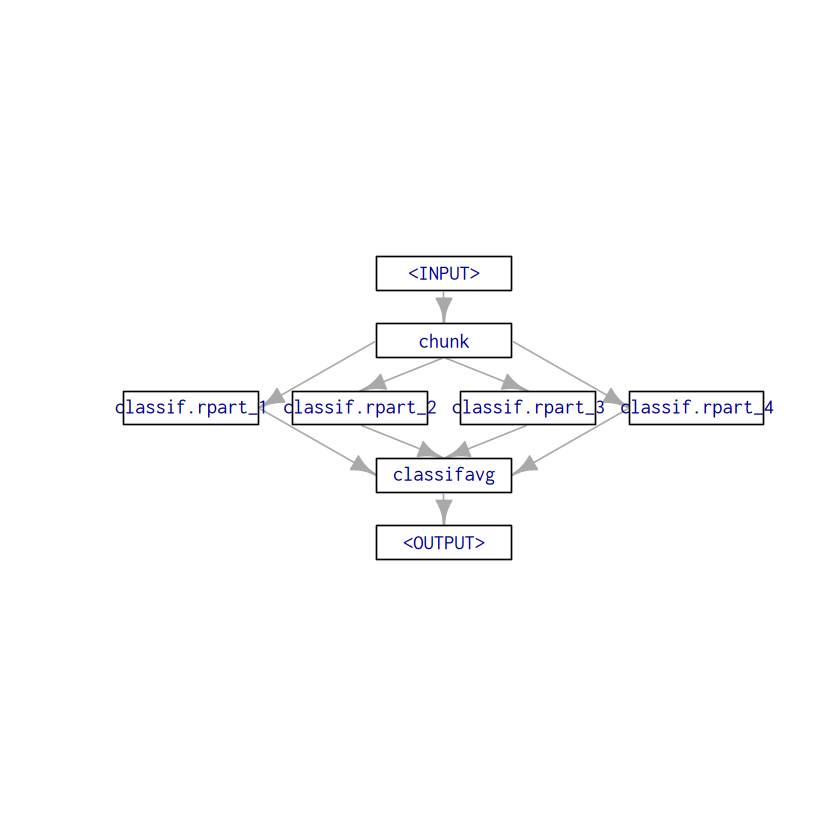

In [39]:
chks <- po("chunk", 4)
lrns <- ppl("greplicate", po("learner", lrn("classif.rpart")), 4)

mjv <- po("classifavg", 4)

pipeline <- chks %>>% lrns %>>% mjv
pipeline$plot(html = FALSE)


In [40]:
task <- tsk("iris")
train.idx <- sample(seq_len(task$nrow), 120)
test.idx <- setdiff(seq_len(task$nrow), train.idx)

pipelrn <- as_learner(pipeline)
pipelrn$train(task, train.idx)$
    predict(task, train.idx)$
    score()


classif.ce 
0.03333333

## 特征选择：PipeOpFilter和PipeOpSelect

可以使用`PipeOpFilter`对象把`mlr3filters`里面的变量选择方法放进mlr3pipelines中。

In [41]:
po("filter", mlr3filters::flt("information_gain"))


PipeOp: <information_gain> (not trained)
values: <list()>
Input channels <name [train type, predict type]>:
  input [Task,Task]
Output channels <name [train type, predict type]>:
  output [Task,Task]

可使用filter_nfeat/filter_frac/filter_cutoff决定保留哪些变量/特征。